# Задача 2: Какие категории фруктов будут заказаны в следующий период

# I. Импорт библиотек

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objs as go 

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import TimeSeriesSplit

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from pandas import Series
from sklearn.feature_selection import f_classif, mutual_info_classif

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import StackingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score
from imblearn.over_sampling import RandomOverSampler

# II. Функции

In [3]:
def metrics(y_test, probs, y_pred_test):
    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)

    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Model ROC AUC = %0.5f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()

    f1_test_n = f1_score(y_test, y_pred_test)
    print('f1 score:=',round(f1_test_n,4))

    precision = precision_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test)
    print('precision: {:.4f}\nrecall: {:.4f}'.format(precision, recall))

    conf_mat = confusion_matrix(y_test, y_pred_test)
    print('Confusion matrix:\n{}'.format(conf_mat))
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,display_labels=model.classes_)
    disp.plot()

In [4]:
def prepare_target(data_n):
    ''' Функция приготовления целевой переменной в выборке'''
    # Приготовление списка категорий в выбранный период времени
    df_cat = data_n.copy()
    df_cat = df_cat.groupby('category').first()
    df_cat.reset_index(inplace=True)
    df_cat = df_cat[['category']]
    
    # Приготовление этикеток целевой переменной
    df_target = data_n.copy()
    # Присваиваем по умолчанию 0
    df_target['target'] = 0
    
    # Если была продажа в последней неделе, то целевая переменная = 1
    df_target.loc[df_target.week == df_target.week.max(), 'target'] = 1
    df_target = df_target[df_target.target == 1]
    df_target = df_target.groupby('category').first()
    df_target = df_target[['target']]
    df_target.reset_index(inplace=True)

    # Соединение общего датасета категории и датасета с категориями, которые купили в контрольную неделю
    df_cat = pd.merge(df_cat,df_target, how='left', on='category')

    # Если категории нет в датафрейме контрольной недели, целевая переменная равна 0
    df_cat.fillna(0, inplace=True)

    df_control = data_n.loc[data_n.week < data_n.week.max()]
    df_bought = df_control.category.unique()
    # Оставим в контрольном периоде только те категории, которые ранее не покупали
    df_cat = df_cat[df_cat.category.isin(df_bought)]
    
    return df_cat.target

In [81]:
def prepare_x(data_n):
    ''' Функция подготовки признаков'''
    df_x = data_n.copy()
    df_x = df_x.loc[df_x.week < df_x.week.max()]
    # Посчитаем, какой период охватывает наша обучающая выборка
    length = (df_x.order_date.max() - df_x.order_date.min()).days
    
    ################################ Feature Engineering ####################################
    
    ###################################### Recency ##########################################
    # Выведем последнюю дату заказа по каждой категории
    df_recent_order = df_x.groupby('category').order_date.max().reset_index()
    df_recent_order.columns = ['category','last_order']
    df_recent_order['recency'] = df_recent_order.last_order.max() - df_recent_order.last_order
    df_recent_order['recency'] = df_recent_order['recency'].astype('timedelta64[D]')
    
    # Создадим признак интервала между заказами в среднем по категории 
    df_interval = pd.DataFrame(columns=['category','interval'])

    for cat in df_x.category.unique():
        i = df_x[df_x.category == cat].order_date.diff().astype('timedelta64[D]')
    #     new_row = {'category':cat, 'interval':i.mean()}
        new_row = {'category':cat, 'interval':i.median()}
        df_interval = df_interval.append(new_row,ignore_index=True)
    # Заполним пропуски значением на 7 дней больше, чем промежуток от начала до конца выборки
    df_interval.fillna(length + 7, inplace=True)
    df_recent_order = pd.merge(df_recent_order,df_interval, how='left', on='category')
    
    
    # Считаем разницу среднего промежутка по категории и последнего заказа
    df_recent_order['median_recent'] = df_recent_order.interval - df_recent_order.recency
    #  Вычитаем длительность контрольного периода, чтобы посчитать остаток
    df_recent_order['remain'] = df_recent_order.median_recent - control_length
    # Создадим бинарный признак, 1 - если промежуток от последнего заказа плюс контрольный период < обычного срока
    df_recent_order['compare'] = df_recent_order.remain.apply(lambda x: 1 if x <= 0 else 0)
    
    ###################################### Frequency ##########################################
    # Считаем количество заказов каждой категории в выборке
    df_frequency = df_x.groupby('category').order_date.count().reset_index()
    df_frequency.columns = ['category','frequency']
    df_features = pd.merge(df_recent_order,df_frequency, how='left', on='category')
    df_last_order = pd.DataFrame(columns=['category','last_volume', 'volume'])

    ###################################### Volume ############################################    
    for cat in df_x.category.unique():  
        df_volume = df_x[['order_date','category','ordered']]
        df_volume = df_volume[df_volume.category == cat]

        # Считаем сумму последнего заказа по категориям
        last_order = df_volume[df_volume.order_date == df_volume.order_date.max()]
        last_order = last_order.groupby(['category']).sum().reset_index()
        last_order.columns = last_order.columns.droplevel(1)

        # Считаем средний срок поставки заказов в выборке по категориям
        volume = df_volume.groupby(['category']).sum().reset_index()
        volume.columns = volume.columns.droplevel(1)

        new_row = {'category':cat, 'last_volume':last_order.ordered[0], 'volume':volume.ordered[0]}
        df_last_order = df_last_order.append(new_row,ignore_index=True)
        
    # Считаем соотношение последнего срока поставки к среднему в выборке
    df_last_order['increase_volume'] = df_last_order.last_volume/df_last_order.volume
    
    # Соединяем с приготовленным датасетом признаков
    df_features = pd.merge(df_features,df_last_order, how='left', on='category')
    
    ###################################### Leadtime ############################################
    
    df_last_leadtime = pd.DataFrame(columns=['category','last_leadtime', 'leadtime'])

    for cat in df_x.category.unique():  
        df_leadtime = df_x[['order_date','category','leadtime']]
        df_leadtime = df_leadtime[df_leadtime.category == cat]

        # Считаем сумму последнего заказа по категориям
        last_leadtime = df_leadtime[df_leadtime.order_date == df_leadtime.order_date.max()]
        last_leadtime = last_leadtime.groupby(['category']).mean().reset_index()
        last_leadtime.columns = last_leadtime.columns.droplevel(1)

        # Считаем средний срок поставки заказов в выборке по категориям
        leadtime = df_leadtime.groupby(['category']).mean().reset_index()
        leadtime.columns = leadtime.columns.droplevel(1)

        new_row = {'category':cat, 'last_leadtime':last_leadtime.leadtime[0], 'leadtime':leadtime.leadtime[0]}
        df_last_leadtime = df_last_leadtime.append(new_row,ignore_index=True)
        
    # Создадим бинарный признак, 1 - если срока поставки >  обычного срока
    df_last_leadtime['leadtime_diff'] = df_last_leadtime.last_leadtime - df_last_leadtime.leadtime
    df_last_leadtime['leadtime_inc'] = df_last_leadtime.leadtime_diff.apply(lambda x: 1 if x > 0 else 0)
    
    # Соединяем датасет признаков
    df_features = pd.merge(df_features,df_last_leadtime, how='left', on='category')
    df_features = df_features[feature_list]
    
    return df_features

# III. Данные

In [16]:
# Загружаем приготовленный датасет
df_village = pd.read_csv('village_table.csv')

In [17]:
df_village

,village,year,family,category,fruit,grade,order_date,delivery_date,ordered,shipped,leadtime
0,Robinhood_village,2020,family_244,category_25,fruit_37,165,2019-12-30,2020-01-03,1650.00,1663.200,4 days
1,Robinhood_village,2020,family_127,category_14,fruit_62,250,2019-12-30,2020-01-10,1000.00,1060.000,11 days
2,Robinhood_village,2020,family_133,category_16,fruit_48,330,2019-12-30,2020-01-08,1320.00,1336.500,9 days
3,Robinhood_village,2020,family_133,category_25,fruit_49,250,2019-12-30,2020-01-08,2500.00,2508.750,9 days
4,Robinhood_village,2020,family_133,category_4,fruit_52,315,2019-12-30,2020-01-08,4725.00,4759.650,9 days
...,...,...,...,...,...,...,...,...,...,...,...
243738,Robinhood_village,2022,family_16,category_87,fruit_474,145,2022-02-19,2022-02-23,287.10,287.100,4 days
243739,Robinhood_village,2022,family_11,category_56,fruit_248,320,2022-02-19,2022-02-25,2561.92,2561.920,6 days
243740,Robinhood_village,2022,family_108,category_16,fruit_410,340,2022-02-20,2022-02-25,1377.00,1377.000,5 days
243741,Robinhood_village,2022,family_278,category_9,fruit_233,252,2022-02-20,2022-02-25,554.40,554.400,5 days


In [18]:
# Преобразуем в формат datetime
df_village.order_date = pd.to_datetime(df_village.order_date)
df_village.delivery_date = pd.to_datetime(df_village.delivery_date)

# Преобразуем в цифровой формат 
df_village['leadtime'] = df_village['leadtime'].apply(lambda x: x[:-5])
df_village['leadtime'] = df_village['leadtime'].astype(int)

In [19]:
df_village.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243743 entries, 0 to 243742
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   village        243743 non-null  object        
 1   year           243743 non-null  int64         
 2   family         243743 non-null  object        
 3   category       243743 non-null  object        
 4   fruit          243743 non-null  object        
 5   grade          243743 non-null  int64         
 6   order_date     243743 non-null  datetime64[ns]
 7   delivery_date  243743 non-null  datetime64[ns]
 8   ordered        243743 non-null  float64       
 9   shipped        243743 non-null  float64       
 10  leadtime       243743 non-null  int64         
dtypes: datetime64[ns](2), float64(2), int64(3), object(4)
memory usage: 20.5+ MB


In [20]:
#  Создадим датафреймы для каждой семьи
for parent in df_village.family.unique():
    globals()[f'{parent}'] = df_village.query(f"family == '{parent}'")

# IV. Задача 2: Предсказывание категорий в следующий период заказов

## 1. Подготовка данных

### 1.1. Преобразования на примере одной семьи

In [21]:
data = family_119.copy()
data = data.sort_values(by='order_date', ascending=True)
    
# Данные по заказам, которые нужно суммировать
data_o = data[['order_date','ordered','category']]
data_o = data_o.groupby(['order_date','category']).agg(['sum'])
# data_o.reset_index(inplace=True)

In [22]:
display(data_o)

ordered
                            sum
order_date category            
2020-01-03 category_3   28000.0
           category_9   30240.0
2020-01-07 category_14   1999.0
           category_16   3996.0
           category_24  20640.0
...                         ...
2022-02-14 category_9   14985.0
2022-02-16 category_16   1998.0
           category_62  48000.0
2022-02-18 category_10  38400.0
           category_8   25974.0

[1836 rows x 1 columns]

Как видно выше, в один день семья может заказать несколько различных категорий фруктов. Может даже быть несколько заказов той же категории. Значит, нужно соответствующим образом сгруппировать данные

In [23]:
# Данные, которые нужно усреднить
data_l = data.copy()
data_l = data_l[['order_date', 'category','leadtime']]
data_l = data_l.groupby(['order_date','category']).agg(['mean'])
# data_l.reset_index(inplace=True)

In [24]:
# Соединяем
data_order_cat = pd.concat([data_o, data_l], axis=1)

In [25]:
data_order_cat.reset_index(inplace=True)

In [26]:
data_order_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1836 entries, 0 to 1835
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   (order_date, )    1836 non-null   datetime64[ns]
 1   (category, )      1836 non-null   object        
 2   (ordered, sum)    1836 non-null   float64       
 3   (leadtime, mean)  1836 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 57.5+ KB


Мы получили сгруппированную таблицу:

In [29]:
data_order_cat.head()

,order_date,category,ordered,leadtime
,,,sum,mean
0,2020-01-03,category_3,28000.0,10.0
1,2020-01-03,category_9,30240.0,10.0
2,2020-01-07,category_14,1999.0,8.0
3,2020-01-07,category_16,3996.0,13.0
4,2020-01-07,category_24,20640.0,15.0


In [30]:
# Найстаршая дата данных
data_order_cat.order_date.min()

Timestamp('2020-01-03 00:00:00')

In [31]:
# Самая поздняя дата 
data_order_cat.order_date.max()

Timestamp('2022-02-18 00:00:00')

### 1.2. Создание новых признаков

#### 1.2.1. Частота (Frequency)

In [32]:
# Выведем количество всех заказов по категории
cat_frequency = data_order_cat.groupby('category').order_date.count().reset_index()
cat_frequency.columns = ['category','frequency']

In [33]:
cat_frequency.head()

,category,frequency
0,category_0,1
1,category_10,20
2,category_102,5
3,category_12,13
4,category_13,10


In [43]:
# plot histogram
hist_fig = px.histogram(x=cat_frequency.category, y=cat_frequency.frequency,
                        title="Количество заказов по категориям", template= "ygridoff" 
                       ).update_xaxes(categoryorder='total ascending')
hist_fig.update_layout(title_x=0.2,
#                        xaxis_title="Categories", 
                       yaxis_title="Number of Orders"
                      )

hist_fig.show(config={'displaylogo': False})

In [35]:
# Катеогории, которые купили менее 5 раз за более, чем два года, стоит удалить
cat_frequency[cat_frequency.frequency < 5]

,category,frequency
0,category_0,1
8,category_157,2
9,category_158,3
11,category_21,3
12,category_217,2
30,category_89,1
32,category_91,3


In [36]:
to_delete = list(cat_frequency[cat_frequency.frequency < 5].category.values)

In [37]:
# Удалим из датасета категории с заказами менее 5
data_order_cat = data_order_cat[~data_order_cat.category.isin(to_delete)]

#### 1.2.2. Интервал 

In [38]:
for cat in data_order_cat.category.unique():
    j = data_order_cat[data_order_cat.category == cat].order_date.diff().astype('timedelta64[D]')
    globals()[f"diff_{cat}"] = j.mean()

In [39]:
# Создадим признак интервала между заказами в среднем по категории 
category_interval = pd.DataFrame(columns=['category','interval'])

for cat in data_order_cat.category.unique():
    i = data_order_cat[data_order_cat.category == cat].order_date.diff().astype('timedelta64[D]')
    new_row = {'category':cat, 'interval':i.mean()}
    category_interval = category_interval.append(new_row,ignore_index=True)

In [44]:
# plot histogram
hist_fig = px.histogram(x=category_interval.category, y=category_interval.interval,
                        title="Интервалы между заказами по категориям", template= "ygridoff" 
                       ).update_xaxes(categoryorder='total descending')
hist_fig.update_layout(title_x=0.2,
#                        xaxis_title="Categories", 
                       yaxis_title="Days between Orders"
                      )

hist_fig.show(config={'displaylogo': False})

### 1.3. Определение целевой переменной

#### 1.3.1. Кодирование признака категории

In [45]:
label_encoder = LabelEncoder()
mapped_category = pd.Series(label_encoder.fit_transform(data_order_cat['category']))
# print(dict(enumerate(label_encoder.classes_)))

In [46]:
data_order_cat['category'] = label_encoder.fit_transform(data_order_cat['category'])
data_order_cat.sample(5)

,order_date,category,ordered,leadtime
,,,sum,mean
101,2020-02-10,11,2280.0,7.000000
1091,2021-05-17,12,29466.0,22.666667
903,2021-02-25,22,14400.0,11.000000
1235,2021-07-06,20,2925.0,50.000000
1757,2022-01-14,10,15480.0,28.000000


#### 1.3.2. Создание признака недели 

In [47]:
data_order_cat['week'] = data_order_cat.order_date.dt.to_period('W')

In [48]:
label_encoder = LabelEncoder()
mapped_week = pd.Series(label_encoder.fit_transform(data_order_cat['week']))
# print(dict(enumerate(label_encoder.classes_)))

In [49]:
data_order_cat['week'] = label_encoder.fit_transform(data_order_cat['week'])

7 - это количество контрольных дней, когда будем проверять, был ли заказ

In [58]:
# train_1 = data_order_cat[data_order_cat.week <= 26]
# val_1 = data_order_cat[(data_order_cat.week > 26)&(data_order_cat.week <= 33)]
control_length = 7 

### 1.4. Preparing Features Set 

In [69]:
feature_list = ['recency', 'interval', 'median_recent', 'remain', 'compare',
       'frequency', 'last_volume', 'volume', 'increase_volume',
       'last_leadtime', 'leadtime', 'leadtime_diff', 'leadtime_inc']

In [64]:
# Пример применения функции приготовления признаков для обучения
train_1 = data_order_cat[data_order_cat.week <= 35]
val_1 = data_order_cat[(data_order_cat.week > 35)&(data_order_cat.week <= 42)]
X_train = prepare_x(train_1)
y_train = prepare_target(train_1)

In [65]:
test = y_train.reset_index()

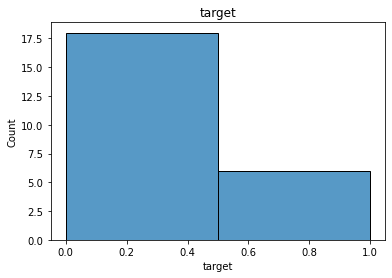

Во сколько раз положительные значения целевой переменной меньше отрицательных: в 3.0 раз


In [66]:
plt.figure()
sns.histplot(test['target'], kde = False, bins=2)
plt.title('target')
plt.show()

times = len(test[test.target == 0])/len(test[test.target == 1])
print(f'Во сколько раз положительные значения целевой переменной меньше отрицательных: в {times} раз')

In [67]:
X_train.head()

,category,last_order,recency,interval,median_recent,remain,compare,frequency,last_volume,volume,increase_volume,last_leadtime,leadtime,leadtime_diff,leadtime_inc
0,0,2020-03-25,156.0,245.0,89.0,82.0,0,1,3900.0,3900.0,1.000000,29.0,29.000,0.000,0
1,1,2020-03-12,169.0,245.0,76.0,69.0,0,1,1920.0,1920.0,1.000000,7.0,7.000,0.000,0
2,2,2020-07-30,29.0,43.0,14.0,7.0,0,4,5496.0,10924.0,0.503112,19.0,17.625,1.375,1
3,4,2020-05-07,113.0,120.0,7.0,0.0,1,2,6000.0,10000.0,0.600000,12.0,9.500,2.500,1
4,5,2020-08-27,1.0,15.0,14.0,7.0,0,7,999.0,7992.0,0.125000,6.0,13.000,-7.000,0


#### Selecting Features

In [68]:
X_train.columns

Index(['category', 'last_order', 'recency', 'interval', 'median_recent',
       'remain', 'compare', 'frequency', 'last_volume', 'volume',
       'increase_volume', 'last_leadtime', 'leadtime', 'leadtime_diff',
       'leadtime_inc'],
      dtype='object')

In [69]:
feature_list = ['recency', 'interval', 'median_recent', 'remain', 'compare',
       'frequency', 'last_volume', 'volume', 'increase_volume',
       'last_leadtime', 'leadtime', 'leadtime_diff', 'leadtime_inc']

In [70]:
X_train = X_train[feature_list]

In [71]:
# train_features

<AxesSubplot:>

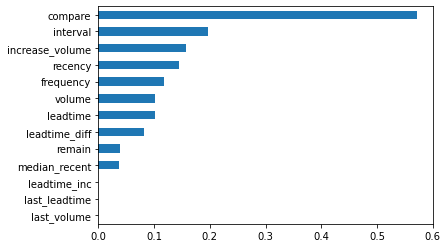

In [72]:
imp_cat = Series(mutual_info_classif(X_train, y_train),
                 index = X_train.columns)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

## Training 

Важным элементом решения задачи является разбитие данных. 

Данные разбиваются последовательно на обучающую и валидационные выборки. Но здесь еще стоит обратить внимание, что мы ищем категории, которые будут покупаться в следующую неделю за обучающей и соответственно валидационной выборкой. Для категорий, которые семья покупала, присвоим значение 1, если нет, то 0.

Поскольку мы имеем дело с меняющимся таймфремом, эту процедуру применим для нескольких выборок. А обучение будет проходить внутри цикла. Посчитаем среднее.

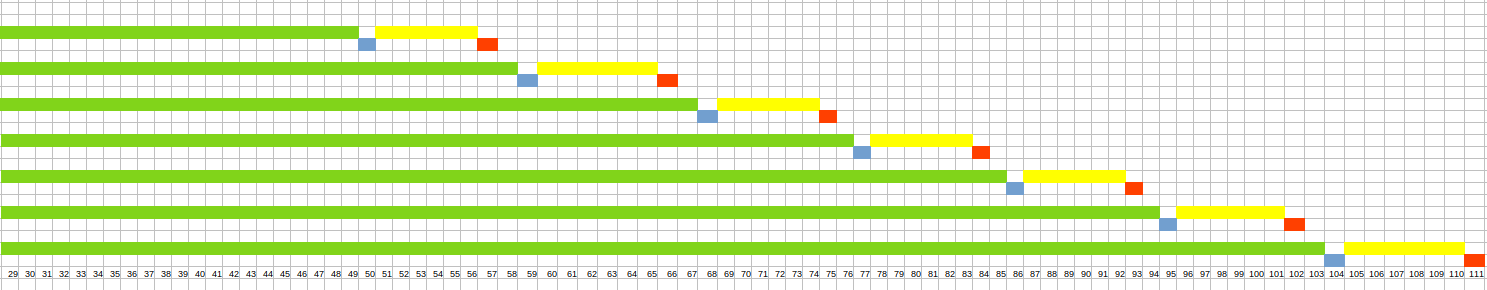

In [73]:
# Данные разобъем вручную:
train_1 = data_order_cat[data_order_cat.week <= 35]
val_1 = data_order_cat[(data_order_cat.week > 35)&(data_order_cat.week <= 42)]
train_2 = data_order_cat[data_order_cat.week <= 44]
val_2 = data_order_cat[(data_order_cat.week > 44)&(data_order_cat.week <= 51)]
train_3 = data_order_cat[data_order_cat.week <= 53]
val_3 = data_order_cat[(data_order_cat.week > 53)&(data_order_cat.week <= 60)]
train_4 = data_order_cat[data_order_cat.week <= 77]
val_4 = data_order_cat[(data_order_cat.week > 77)&(data_order_cat.week <= 84)]
train_5 = data_order_cat[data_order_cat.week <= 86]
val_5 = data_order_cat[(data_order_cat.week > 86)&(data_order_cat.week <= 93)]
train_6 = data_order_cat[data_order_cat.week <= 104]
val_6 = data_order_cat[(data_order_cat.week > 104)&(data_order_cat.week <= 111)]

In [77]:
data_order_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1821 entries, 0 to 1835
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   (order_date, )    1821 non-null   datetime64[ns]
 1   (category, )      1821 non-null   int64         
 2   (ordered, sum)    1821 non-null   float64       
 3   (leadtime, mean)  1821 non-null   float64       
 4   (week, )          1821 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 85.4 KB


###  Тестируем различные модели

**Логистическая регрессия**

In [82]:
feature_list = ['recency', 'interval', 'median_recent', 'remain', 'compare','last_volume', 
                'increase_volume', 'last_leadtime', 'leadtime', 'leadtime_inc']

In [83]:
log_reg_score = []
for i in range (1,7):
    globals()[f"X_train_{i}"] = prepare_x(globals()[f"train_{i}"])
    globals()[f"X_val_{i}"] = prepare_x(globals()[f"val_{i}"])
    X_train = prepare_x(globals()[f"train_{i}"])
    X_train = X_train[feature_list]
    y_train = prepare_target(globals()[f"train_{i}"])
    
    ros = RandomOverSampler(sampling_strategy=0.92, random_state=42)
    X_train, y_train = ros.fit_resample(X_train, y_train)
    
    X_val = prepare_x(globals()[f"val_{i}"])
    X_val = X_val[feature_list]
    y_val = prepare_target(globals()[f"val_{i}"])

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train) 
    X_val = scaler.transform(X_val)
    
    log_reg = LogisticRegression(C=0.000001,
                                 random_state = 42,
                                 penalty='l2',
                                 max_iter=80, 
                                 class_weight='balanced',
                                 solver='liblinear' 
                                )
    log_reg.fit(X_train, y_train)
    y_pred_val = log_reg.predict(X_val)
    f1 = f1_score(y_val, y_pred_val)
    log_reg_score.append(f1)
    
log_reg_f1 = round(np.mean(log_reg_score),3)
print(log_reg_f1)

0.692


**Bagging**

In [84]:
feature_list = ['recency','interval','median_recent', 'remain', 'compare', 'increase_volume', 'last_leadtime', ]

In [85]:
# X_train.info()

In [86]:
# feature_list = ['recency','interval','median_recent', 'remain', 'compare', 'increase_volume', 'last_leadtime', ]

bagging_score = []
for i in range (1,7):
    globals()[f"X_train_{i}"] = prepare_x(globals()[f"train_{i}"])
    globals()[f"X_val_{i}"] = prepare_x(globals()[f"val_{i}"])
    X_train = prepare_x(globals()[f"train_{i}"])
    y_train = prepare_target(globals()[f"train_{i}"])
    
    X_val = prepare_x(globals()[f"val_{i}"])
    y_val = prepare_target(globals()[f"val_{i}"])

    # Стандартизируем числовые переменные, записываем в матрицу X
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train) 
    X_val = scaler.transform(X_val)
    
    clf = LogisticRegression(C=0.001,random_state = 42,
                                 penalty='l2',
                                 max_iter=70, 
                                 class_weight='balanced',
                                 solver='liblinear')

    bagging = BaggingClassifier(clf, n_estimators=74, random_state=42, n_jobs=-1, oob_score=True)
    
    
    bagging.fit(X_train, y_train)
    # Предсказываем на валидационной выборке
    y_pred_val = bagging.predict(X_val)
    f1 = f1_score(y_val, y_pred_val)
    bagging_score.append(f1)
    
bagging_f1 = round(np.mean(bagging_score),3)
print(bagging_f1)

0.67


**XGB классификатор**

In [87]:
feature_list = ['recency', 'interval', 'median_recent', 'remain', 'compare','frequency', 
                'last_volume', 'increase_volume','last_leadtime', 'leadtime','leadtime_diff', 'leadtime_inc']

In [88]:
xgb_score = []
for i in range (1,7):
    globals()[f"X_train_{i}"] = prepare_x(globals()[f"train_{i}"])
    globals()[f"X_val_{i}"] = prepare_x(globals()[f"val_{i}"])
    X_train = prepare_x(globals()[f"train_{i}"])
    y_train = prepare_target(globals()[f"train_{i}"])
    
    ros = RandomOverSampler(sampling_strategy=0.92, random_state=42)
    X_train, y_train = ros.fit_resample(X_train, y_train)
    
    X_val = prepare_x(globals()[f"val_{i}"])
    y_val = prepare_target(globals()[f"val_{i}"])

    # Стандартизируем числовые переменные, записываем в матрицу X
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train) 
    X_val = scaler.transform(X_val)
    
    xgb = XGBClassifier(objective ='reg:squarederror',
                        random_state = 42,
                        colsample_bytree = 0.02, 
                        learning_rate = 0.00015, 
                        use_label_encoder=False, 
                        scale_pos_weight=2,
                        max_depth = 6, 
                        alpha = 1, 
                        n_estimators = 80, 
                        eval_metric='mlogloss')
                                         
    xgb.fit(X_train, y_train)
    # Предсказываем на валидационной выборке
    y_pred_val = xgb.predict(X_val)
    f1 = f1_score(y_val, y_pred_val)
    xgb_score.append(f1)
    
xgb_f1 = round(np.mean(xgb_score),3)
print(xgb_f1)

0.674


**CatBoost классификатор**

In [89]:
feature_list = ['recency', 'interval', 'median_recent', 'remain', 'compare','last_leadtime',]

In [90]:
cat_boost_score = []
for i in range (1,7):
    globals()[f"X_train_{i}"] = prepare_x(globals()[f"train_{i}"])
    globals()[f"X_val_{i}"] = prepare_x(globals()[f"val_{i}"])
    X_train = prepare_x(globals()[f"train_{i}"])
    y_train = prepare_target(globals()[f"train_{i}"])
    
    X_val = prepare_x(globals()[f"val_{i}"])
    y_val = prepare_target(globals()[f"val_{i}"])

    # Стандартизируем числовые переменные, записываем в матрицу X
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train) 
    X_val = scaler.transform(X_val)
    
    cat_boost = CatBoostClassifier(verbose=False,
                                   n_estimators = 600,
                                   l2_leaf_reg= 2,
                                   min_data_in_leaf = 2,
                                   depth=8,
                                   learning_rate = 0.4,
                                   random_seed = 42, )
    
    cat_boost.fit(X_train, y_train)
    # Предсказываем на валидационной выборке
    y_pred_val = cat_boost.predict(X_val)
    f1 = f1_score(y_val, y_pred_val)
    cat_boost_score.append(f1)
    
cat_boost_f1 = round(np.mean(cat_boost_score),3)
print(cat_boost_f1)

0.651


**ExtraTree классификатор**

In [91]:
feature_list = ['recency', 'remain', 'compare', 'last_volume', 'last_leadtime', 
                'leadtime_diff', 'leadtime_inc']

In [92]:
x_tree_score = []
for i in range (1,7):
    globals()[f"X_train_{i}"] = prepare_x(globals()[f"train_{i}"])
    globals()[f"X_val_{i}"] = prepare_x(globals()[f"val_{i}"])
    X_train = prepare_x(globals()[f"train_{i}"])
    y_train = prepare_target(globals()[f"train_{i}"])
    
    X_val = prepare_x(globals()[f"val_{i}"])
    y_val = prepare_target(globals()[f"val_{i}"])

    # Стандартизируем числовые переменные, записываем в матрицу X
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train) 
    X_val = scaler.transform(X_val)
    
    
    x_tree = ExtraTreesClassifier(random_state=42, 
                                 max_depth=8,
                                 n_estimators = 120,
                                 class_weight='balanced_subsample',
                                 min_samples_split = 7,
                                 max_features='auto' )
    
    x_tree.fit(X_train, y_train)
    # Предсказываем на валидационной выборке
    y_pred_val = x_tree.predict(X_val)
    f1 = f1_score(y_val, y_pred_val)
    x_tree_score.append(f1)
    
x_tree_f1 = round(np.mean(x_tree_score),3)
print(x_tree_f1)

0.702


**Random Forest классификатор**

In [93]:
feature_list = ['recency', 'interval', 'median_recent','remain', 'compare','last_volume', 
                'increase_volume','last_leadtime','leadtime', 'leadtime_diff', 'leadtime_inc']

In [94]:
forest_score = []
for i in range (1,7):
    globals()[f"X_train_{i}"] = prepare_x(globals()[f"train_{i}"])
    globals()[f"X_val_{i}"] = prepare_x(globals()[f"val_{i}"])
    X_train = prepare_x(globals()[f"train_{i}"])
    y_train = prepare_target(globals()[f"train_{i}"])
    
    ros = RandomOverSampler(sampling_strategy=0.92, random_state=42)
    X_train, y_train = ros.fit_resample(X_train, y_train)
    
    X_val = prepare_x(globals()[f"val_{i}"])
    y_val = prepare_target(globals()[f"val_{i}"])

    # Стандартизируем числовые переменные, записываем в матрицу X
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train) 
    X_val = scaler.transform(X_val)
    
    forest = RandomForestClassifier(n_estimators=1000,
                                    random_state = 42,
                                    n_jobs=-1,
                                    max_features=9,
                                    max_depth=7,
                                    class_weight='balanced_subsample',
                                    ccp_alpha=0.06)
    
    forest.fit(X_train, y_train)
    # Предсказываем на валидационной выборке
    y_pred_val = forest.predict(X_val)
    f1 = f1_score(y_val, y_pred_val)
    forest_score.append(f1)
    
random_forest_f1 = round(np.mean(forest_score),3)
print(random_forest_f1)

0.61


###  Итоги

In [95]:
models  = {'log_reg': log_reg_f1, 'bagging': bagging_f1, 'xgb':xgb_f1, 'cat_boost':cat_boost_f1,
                       'x_tree': x_tree_f1, 'random_forest':random_forest_f1}
results = pd.DataFrame(list(models.items()), columns = ['models','evaluation'])
results

,models,evaluation
0,log_reg,0.692
1,bagging,0.670
2,xgb,0.674
3,cat_boost,0.651
4,x_tree,0.702
5,random_forest,0.610


In [96]:
results = results.sort_values(['evaluation'], ascending=False)

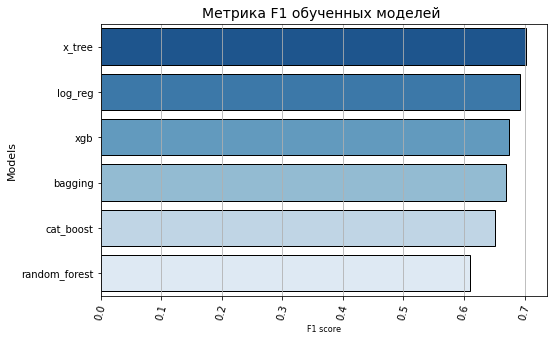

In [97]:
plt.figure(figsize=(8,5))
plt.grid(True)
plt.xticks(rotation=75)
plt.title('Метрика F1 обученных моделей ',fontsize=14)
bar_plot = sns.barplot(data=results, x='evaluation', y='models', capsize= 0.00001,
                       palette='Blues_r',linewidth=1,edgecolor=".001")
plt.xlabel('F1 score', fontsize=8)
plt.ylabel('Models', fontsize=11)
plt.show()

Целью задачи 2 было предсказание, какие категории будут заказаны в последующую неделю

Задача решалась с помощью классификации: будет ли заказанная категория в продажах на следующей неделе или нет.
Были созданы признаки, которые могут влиять на предсказание. Эти признаки связаны с последними заказами,  регулярностью заказов, периодичностью заказов, а также сравнением объемов последних заказов с обучным.  
Важным элементом является соответствующее разбиение на обучающую и валидационную выборк, определение целевой переменной хронологичечски. Нельзя допустить, чтобы данные признаков "видели", были ли заказы в коннтрольный период или нет.

Для оптимизации результатов работы алгоритмов кроме настройки гиперпараметров необходимо также соответственно выбирать признаки.

Наилучший резельтат получил алгортим extra tree classificator